In [21]:
import pandas as pd
import os
import json
import numpy as np
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
from nameparser import HumanName
from ethnicolr import pred_census_ln
from itertools import combinations
from collections import Counter, defaultdict
from matplotlib.lines import Line2D
from scipy.stats import zscore
from collections import Counter
import seaborn as sns

In [18]:
path_connected_data = "C:\\Users\\tykun\\OneDrive\\Documents\\SchoolDocs\\VSCodeProjects\\connectedData\\dataframes\\"
path_temp_data = "C:\\Users\\tykun\\OneDrive\\Documents\\SchoolDocs\\VSCodeProjects\\connectedData\\temporaryData\\"
year = "2009"
valid_years = ["1999", "2000", "2005", "2008", "2009", "2013"]

path_read = f"{path_connected_data}{year}_split_positions.csv"
boards_path = f"{path_temp_data}{year}_boards.csv"
institution_gender_path = f"{path_temp_data}institution_gender.csv"

In [13]:
def get_last_name(full_name):
    full_name = HumanName(full_name)
    return str(full_name.last)

numbers_by_year = {}
for year in valid_years:
    current_year_dict = {'white': 0, 'poc': 0, 'unknown': 0}
    boards_path = f"{path_temp_data}{year}_boards.csv"
    board_df = pd.read_csv(boards_path)
    
    board_df['last_name'] = board_df['Name'].apply(get_last_name)
    board_df = pred_census_ln(board_df, 'last_name')
    
    for _, row in board_df.iterrows():
        ethnicity = row['race'] 
        if ethnicity == 'white':
            current_year_dict['white'] += 1
        elif ethnicity in ['api', 'black', 'hispanic', 'aian']:
            current_year_dict['poc'] += 1
        else:
            current_year_dict['unknown'] += 1
    
    numbers_by_year[year] = current_year_dict

df = pd.DataFrame(numbers_by_year).T


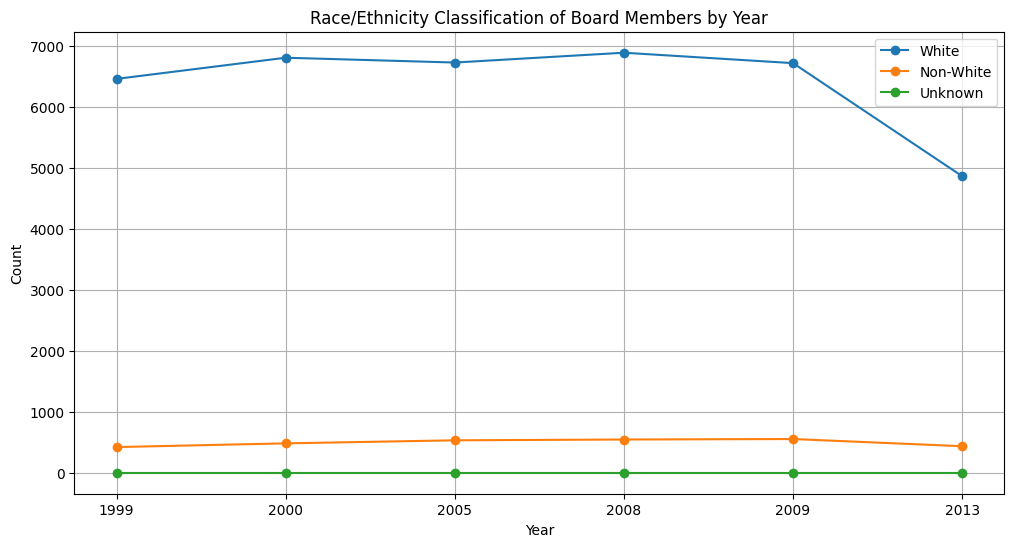

In [14]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['white'], label='White', marker='o')
plt.plot(df.index, df['poc'], label='Non-White', marker='o')
plt.plot(df.index, df['unknown'], label='Unknown', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Race/Ethnicity Classification of Board Members by Year')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
d = gender.Detector()
numbers_by_year = {}
institution_distributions = []

for year in valid_years:
    current_year_dict = {'male': 0, 'female': 0, 'unknown': 0}
    boards_path = f"{path_temp_data}{year}_boards.csv"
    board_df = pd.read_csv(boards_path)
    
    for _, row in board_df.iterrows():
        name = HumanName(row["Name"])
        first_name = str(name.first)
        
        current_gender = d.get_gender(first_name)
        if current_gender in ['male', 'female']:
            current_year_dict[current_gender] += 1
        else:
            current_year_dict['unknown'] += 1

        institution_distributions.append({
            'year': year,
            'institution': row['Institution'],
            'gender': current_gender
        })
    
    numbers_by_year[year] = current_year_dict

df_yearly = pd.DataFrame(numbers_by_year).T
df_institution = pd.DataFrame(institution_distributions)

df_institution_grouped = df_institution.groupby(['year', 'institution', 'gender']).size().unstack(fill_value=0).reset_index()

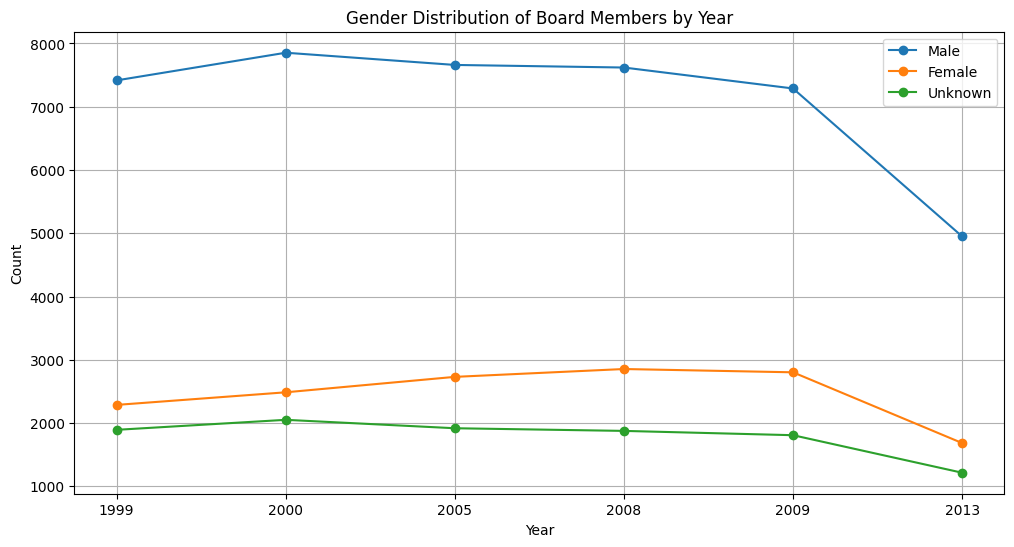

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['male'], label='Male', marker='o')
plt.plot(df.index, df['female'], label='Female', marker='o')
plt.plot(df.index, df['unknown'], label='Unknown', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Gender Distribution of Board Members by Year')
plt.legend()
plt.grid(True)
plt.show()
df_institution_grouped.to_csv(institution_gender_path, index = False)

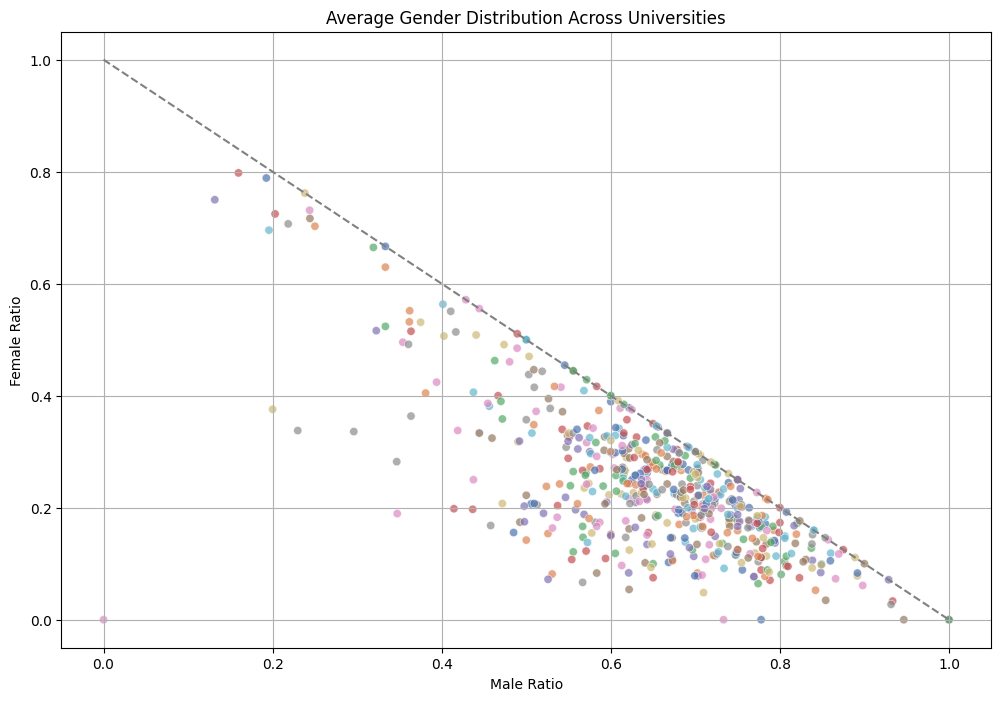

In [25]:
# Calculate the average gender distribution for each institution across all years
df_avg_gender_by_institution = df_institution_grouped.groupby('institution').agg({
    'male': 'mean',
    'female': 'mean',
    'unknown': 'mean'
}).reset_index()

df_avg_gender_by_institution['total'] = df_avg_gender_by_institution['male'] + df_avg_gender_by_institution['female'] + df_avg_gender_by_institution['unknown']
df_avg_gender_by_institution['male_ratio'] = df_avg_gender_by_institution['male'] / df_avg_gender_by_institution['total']
df_avg_gender_by_institution['female_ratio'] = df_avg_gender_by_institution['female'] / df_avg_gender_by_institution['total']

# Plot the gender distribution as dots
plt.figure(figsize=(12, 8))

sns.scatterplot(x=df_avg_gender_by_institution['male_ratio'], 
                y=df_avg_gender_by_institution['female_ratio'], 
                hue=df_avg_gender_by_institution['institution'], 
                palette='deep', alpha=0.7, legend=None)

plt.xlabel('Male Ratio')
plt.ylabel('Female Ratio')
plt.title('Average Gender Distribution Across Universities')
plt.grid(True)

# Adding a line to represent the balance point (where male_ratio + female_ratio = 1)
plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

plt.show()